# https://scib-metrics.readthedocs.io/en/latest/notebooks/lung_example.html

Random seed set as 42
/home/figo/software/python_libs/scbiot/examples
/home/figo/software/python_libs/scbiot


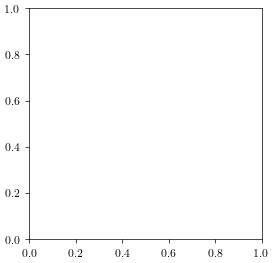

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import seaborn as sns
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
import torch
import os
import pandas as pd
import scbiot as scb
from scbiot.utils import set_seed

import harmonypy as hm
from umap import UMAP
# %pip install scib-metrics
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

set_seed(42)

from pathlib import Path
dir = Path.cwd()
print(dir)
parent_dir = dir.parent
print(parent_dir)

from scimorph.theme_publication import theme_publication
from scimorph.utils import set_seed
theme_publication()


In [ ]:
adata_path = f"{dir}/inputs/multiome.h5ad"
adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/59742665"
)



AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
# split to gex and peaks
gex_vars = adata.var['feature_types'] == 'GEX'
adata_gex = adata[:, gex_vars].copy()

# Filter for ATAC-related variables
atac_vars = adata.var['feature_types'] == 'ATAC'
adata_atac = adata[:, atac_vars].copy()

In [4]:
sc.pp.normalize_per_cell(adata_gex, counts_per_cell_after=1e4)
sc.pp.log1p(adata_gex)
sc.pp.highly_variable_genes(adata_gex, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata_gex, n_comps=30, use_highly_variable=True)

# save back
adata.obsm["X_pca"] = adata_gex.obsm["X_pca"]

In [ ]:
# figshare gtf file link: https://figshare.com/ndownloader/files/59742635

adata_top = scb.pp.remove_promoter_proximal_peaks(adata_atac, gtf_file=f'{dir}/inputs/gencode.v48.chr_patch_hapl_scaff.basic.annotation.gtf.gz')

# Peak selection
scb.pp.find_variable_features(adata_top, topN=30000, batch_key="batch")

scb.pp.add_iterative_lsi(adata_top, n_components=31, drop_first_component=True, add_key="X_lsi")


# Save back
adata_atac.obsm["X_lsi"] = adata_top.obsm["X_lsi"]
adata.obsm["X_lsi"] = adata_top.obsm["X_lsi"]


Removed 28,633 promoter-proximal peaks (2000bp upstream / 500bp downstream). Remaining: 87,857
Running Iterative LSI iteration 1 ...
Running Iterative LSI iteration 2 ...
Running Iterative LSI iteration 3 ...
Running Iterative LSI iteration 4 ...
Running Iterative LSI iteration 5 ...


In [6]:
adata, metrics = scb.ot.integrate(
    adata,
    modality='paired',
    obsm_key="X_pca",              # base view for geometry/smoothing
    batch_key="batch",
    out_key="X_ot",
    mode="ufgw_barycenter",        
    view_keys=("X_pca", "X_lsi"),   
    
)
print(metrics)

[baseline] KNN backend=FAISS-GPU mix=1.3245 strain=0.00000 mode=ufgw_barycenter
[iter 01] mix=1.384 overlap0=0.939 strain=0.00035 J=0.163 best_it=1
[iter 02] mix=1.451 overlap0=0.884 strain=0.00133 J=0.224 best_it=2
[iter 03] mix=1.519 overlap0=0.827 strain=0.00290 J=0.281 best_it=3
[iter 04] mix=1.583 overlap0=0.770 strain=0.00506 J=0.335 best_it=4
[iter 05] mix=1.642 overlap0=0.710 strain=0.00781 J=0.381 best_it=5
[iter 06] mix=1.696 overlap0=0.649 strain=0.01110 J=0.422 best_it=6
[iter 07] mix=1.741 overlap0=0.589 strain=0.01507 J=0.442 best_it=7
[iter 08] mix=1.775 overlap0=0.530 strain=0.01954 J=0.436 best_it=7
[iter 09] mix=1.776 overlap0=0.528 strain=0.01961 J=0.430 best_it=7
[iter 10] mix=1.775 overlap0=0.528 strain=0.01953 J=0.426 best_it=7
[early stop] plateau reached.
[final] it*=7 mix=1.741 overlap0=0.589 strain=0.01507 tw=0.994
{'mix': 1.740976671515229, 'overlap0': 0.5894866585731506, 'strain': 0.015066716820001602, 'tw': 0.9935072506280981, 'it': 7}


In [7]:
sc.pp.neighbors(adata, use_rep='X_ot', n_neighbors=8)
sc.tl.umap(adata, min_dist=0.10, spread=1.0)
sc.tl.leiden(adata, key_added='leiden_X_ot', resolution=0.8)

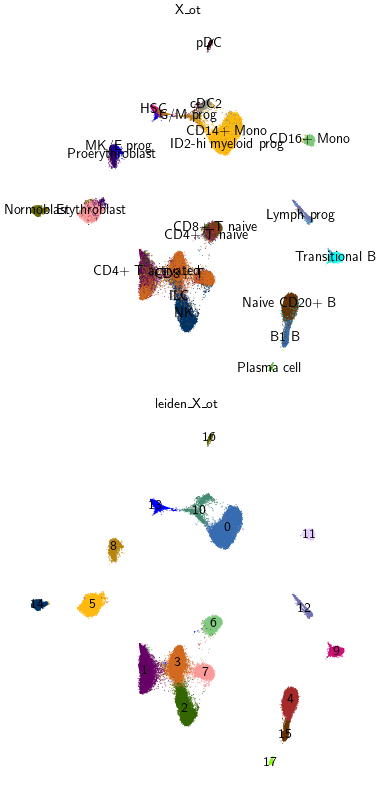

In [8]:
import matplotlib.pyplot as plt
import scanpy as sc

methods = ["X_ot"]

# 2 rows x len(methods) columns
fig, axes = plt.subplots(
    2,
    len(methods),
    figsize=(4 * len(methods), 8),
    squeeze=False  # ensures axes is a 2D array
)

for col, method in enumerate(methods):
    # 1) Top row (row=0): color by "batch"
    sc.pl.embedding(
        adata,
        basis=f"X_umap",  # The coordinates stored in adata.obsm["X_umap_{method}"]
        color="cell_type",            # Assume adata.obs["batch"] exists
        frameon=False,
        ax=axes[0, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        title=f"{method}"
    )

    # 2) Bottom row (row=1): color by the Leiden clusters for this method
    leiden_key = f"leiden_{method}"
    sc.pl.embedding(
        adata,
        basis=f"X_umap",
        color=leiden_key,         # Column in adata.obs
        frameon=False,
        ax=axes[1, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        # title=f"{method}"
    )

plt.tight_layout()
# fig.savefig("batch_and_leiden_per_embedding.pdf", dpi=300)
# plt.close(fig)


In [9]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

df = pd.DataFrame(adata.obsm['X_ot'], index=adata.obs.index) # adata.X.toarray()
df['batch'] = adata.obs['batch']

df['target'] = adata.obs['cell_type']
# Step 1: Get the counts of each category
category_counts = df['target'].value_counts()
# Step 2: Create a mapping of categories to numbers based on descending counts
category_mapping = {category: idx for idx, category in enumerate(category_counts.index)}
# Step 3: Map the original categorical column to the new numeric values
df['target'] = df['target'].map(category_mapping)

df['pseudo'] = adata.obs['leiden_X_ot'] #adata.obs['leiden_multiome_harmony']
# Step 1: Get the counts of each category
category_counts = df['pseudo'].value_counts()
# Step 2: Create a mapping of categories to numbers based on descending counts
category_mapping = {category: idx for idx, category in enumerate(category_counts.index)}
# Step 3: Map the original categorical column to the new numeric values
df['pseudo'] = df['pseudo'].map(category_mapping)

df = df.reset_index().set_index(['index', 'batch', 'target', 'pseudo'])

# Extract numeric labels
true_labels = df.reset_index()['target']
pred_labels = df.reset_index()['pseudo']

# Calculate NMI
nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
ari_score = adjusted_rand_score(true_labels, pred_labels)

print("NMI:", nmi_score)
print("ARI:", ari_score)


NMI: 0.7499850773867841
ARI: 0.6406373241629348


In [10]:
scb.pp.setup_anndata(adata, var_key='X_ot', batch_key='batch', pseudo_key='leiden_X_ot', true_key=None)

{'var_key': 'X_ot',
 'batch_key': 'batch',
 'pseudo_key': 'leiden_X_ot',
 'true_key': None}

In [11]:
model = scb.models.vae(adata, prior_pcr=5, verbose=True)

Random seed set as 42
[Explicit labels] has_pseudo=True
[Explicit labels] batch_train/test: torch.Size([62324]) / torch.Size([6925])
[Explicit labels] pseudo_train/test: torch.Size([62324]) / torch.Size([6925])


In [12]:
model.train()

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Saved whole dataset latents (N=69249)


Training:   1%|▏         | 1/80 [00:04<05:50,  4.43s/it, epoch=1/80, Train_loss=2.6007, Test_loss=2.1002]

{'Train NMI': 0.186, 'Train ARI': 0.087, 'Train ACC': 0.256, 'Train kBET': 0.934, 'Train CCR': 0.0}


Training:   2%|▎         | 2/80 [00:06<04:03,  3.12s/it, epoch=2/80, Train_loss=2.7780, Test_loss=2.3019]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.518, 'Train ARI': 0.371, 'Train ACC': 0.57, 'Train kBET': 0.901, 'Train CCR': 2.43}


Training:   4%|▍         | 3/80 [00:08<03:16,  2.56s/it, epoch=3/80, Train_loss=2.6982, Test_loss=2.5034]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.663, 'Train ARI': 0.49, 'Train ACC': 0.643, 'Train kBET': 0.774, 'Train CCR': 57.39}


Training:   5%|▌         | 4/80 [00:10<03:03,  2.42s/it, epoch=4/80, Train_loss=2.7525, Test_loss=2.4133]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.7, 'Train ARI': 0.525, 'Train ACC': 0.633, 'Train kBET': 0.721, 'Train CCR': 75.221}


Training:   6%|▋         | 5/80 [00:12<02:47,  2.23s/it, epoch=5/80, Train_loss=2.6069, Test_loss=2.3601]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.76, 'Train ARI': 0.603, 'Train ACC': 0.694, 'Train kBET': 0.698, 'Train CCR': 85.462}


Training:   8%|▊         | 6/80 [00:14<02:36,  2.12s/it, epoch=6/80, Train_loss=2.5287, Test_loss=2.3187]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.794, 'Train ARI': 0.662, 'Train ACC': 0.73, 'Train kBET': 0.692, 'Train CCR': 88.092}


Training:   9%|▉         | 7/80 [00:16<02:36,  2.14s/it, epoch=7/80, Train_loss=2.2951, Test_loss=2.1575]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.803, 'Train ARI': 0.668, 'Train ACC': 0.714, 'Train kBET': 0.679, 'Train CCR': 90.683}


Training:  10%|█         | 8/80 [00:18<02:29,  2.07s/it, epoch=8/80, Train_loss=2.1640, Test_loss=2.0766]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.804, 'Train ARI': 0.663, 'Train ACC': 0.708, 'Train kBET': 0.67, 'Train CCR': 94.699}


Training:  11%|█▏        | 9/80 [00:20<02:28,  2.10s/it, epoch=9/80, Train_loss=2.1163, Test_loss=2.0303]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.817, 'Train ARI': 0.687, 'Train ACC': 0.719, 'Train kBET': 0.659, 'Train CCR': 96.064}


Training:  12%|█▎        | 10/80 [00:22<02:23,  2.04s/it, epoch=10/80, Train_loss=2.0233, Test_loss=1.9839]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.828, 'Train ARI': 0.706, 'Train ACC': 0.749, 'Train kBET': 0.656, 'Train CCR': 97.289}


Training:  14%|█▍        | 11/80 [00:24<02:15,  1.96s/it, epoch=11/80, Train_loss=1.9789, Test_loss=1.9391]

{'Train NMI': 0.813, 'Train ARI': 0.709, 'Train ACC': 0.726, 'Train kBET': 0.647, 'Train CCR': 98.012}


Training:  15%|█▌        | 12/80 [00:26<02:11,  1.93s/it, epoch=12/80, Train_loss=1.9466, Test_loss=1.9297]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.833, 'Train ARI': 0.725, 'Train ACC': 0.748, 'Train kBET': 0.643, 'Train CCR': 98.313}


Training:  16%|█▋        | 13/80 [00:28<02:06,  1.89s/it, epoch=13/80, Train_loss=1.9271, Test_loss=1.8998]

{'Train NMI': 0.827, 'Train ARI': 0.687, 'Train ACC': 0.734, 'Train kBET': 0.634, 'Train CCR': 98.976}


Training:  18%|█▊        | 14/80 [00:29<01:56,  1.77s/it, epoch=14/80, Train_loss=1.9026, Test_loss=1.8873]

{'Train NMI': 0.823, 'Train ARI': 0.708, 'Train ACC': 0.729, 'Train kBET': 0.634, 'Train CCR': 98.976}


Training:  19%|█▉        | 15/80 [00:31<01:54,  1.77s/it, epoch=15/80, Train_loss=1.8971, Test_loss=1.8786]

{'Train NMI': 0.819, 'Train ARI': 0.69, 'Train ACC': 0.712, 'Train kBET': 0.634, 'Train CCR': 98.815}


Training:  20%|██        | 16/80 [00:32<01:47,  1.68s/it, epoch=16/80, Train_loss=1.8844, Test_loss=1.8701]

{'Train NMI': 0.828, 'Train ARI': 0.721, 'Train ACC': 0.732, 'Train kBET': 0.636, 'Train CCR': 99.157}


Training:  21%|██▏       | 17/80 [00:34<01:42,  1.62s/it, epoch=17/80, Train_loss=1.9107, Test_loss=1.8742]

{'Train NMI': 0.821, 'Train ARI': 0.708, 'Train ACC': 0.731, 'Train kBET': 0.634, 'Train CCR': 98.454}


Training:  22%|██▎       | 18/80 [00:36<01:43,  1.67s/it, epoch=18/80, Train_loss=1.8888, Test_loss=1.8745]

{'Train NMI': 0.826, 'Train ARI': 0.709, 'Train ACC': 0.728, 'Train kBET': 0.634, 'Train CCR': 98.474}


Training:  24%|██▍       | 19/80 [00:37<01:38,  1.61s/it, epoch=19/80, Train_loss=1.8823, Test_loss=1.8627]

{'Train NMI': 0.821, 'Train ARI': 0.698, 'Train ACC': 0.727, 'Train kBET': 0.634, 'Train CCR': 98.554}


Training:  25%|██▌       | 20/80 [00:39<01:39,  1.66s/it, epoch=20/80, Train_loss=1.8743, Test_loss=1.8588]

{'Train NMI': 0.826, 'Train ARI': 0.694, 'Train ACC': 0.729, 'Train kBET': 0.639, 'Train CCR': 99.096}


Training:  26%|██▋       | 21/80 [00:41<01:41,  1.72s/it, epoch=21/80, Train_loss=1.8680, Test_loss=1.8551]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.833, 'Train ARI': 0.723, 'Train ACC': 0.754, 'Train kBET': 0.635, 'Train CCR': 99.177}


Training:  28%|██▊       | 22/80 [00:43<01:41,  1.75s/it, epoch=22/80, Train_loss=1.8650, Test_loss=1.8509]

{'Train NMI': 0.822, 'Train ARI': 0.716, 'Train ACC': 0.733, 'Train kBET': 0.635, 'Train CCR': 98.896}


Training:  29%|██▉       | 23/80 [00:44<01:42,  1.80s/it, epoch=23/80, Train_loss=1.8612, Test_loss=1.8521]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.835, 'Train ARI': 0.715, 'Train ACC': 0.756, 'Train kBET': 0.632, 'Train CCR': 98.795}


Training:  30%|███       | 24/80 [00:47<01:46,  1.91s/it, epoch=24/80, Train_loss=1.8562, Test_loss=1.8553]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.841, 'Train ARI': 0.745, 'Train ACC': 0.778, 'Train kBET': 0.635, 'Train CCR': 99.036}


Training:  31%|███▏      | 25/80 [00:48<01:39,  1.80s/it, epoch=25/80, Train_loss=1.8759, Test_loss=1.8662]

{'Train NMI': 0.834, 'Train ARI': 0.727, 'Train ACC': 0.774, 'Train kBET': 0.634, 'Train CCR': 98.996}


Training:  32%|███▎      | 26/80 [00:50<01:36,  1.79s/it, epoch=26/80, Train_loss=1.8625, Test_loss=1.8503]

{'Train NMI': 0.83, 'Train ARI': 0.716, 'Train ACC': 0.753, 'Train kBET': 0.636, 'Train CCR': 98.554}


Training:  34%|███▍      | 27/80 [00:51<01:30,  1.70s/it, epoch=27/80, Train_loss=1.8565, Test_loss=1.8385]

{'Train NMI': 0.826, 'Train ARI': 0.698, 'Train ACC': 0.743, 'Train kBET': 0.637, 'Train CCR': 98.655}


Training:  35%|███▌      | 28/80 [00:53<01:25,  1.64s/it, epoch=28/80, Train_loss=1.8540, Test_loss=1.8393]

{'Train NMI': 0.816, 'Train ARI': 0.702, 'Train ACC': 0.714, 'Train kBET': 0.643, 'Train CCR': 98.153}


Training:  36%|███▋      | 29/80 [00:55<01:25,  1.68s/it, epoch=29/80, Train_loss=1.8491, Test_loss=1.8391]

{'Train NMI': 0.834, 'Train ARI': 0.72, 'Train ACC': 0.758, 'Train kBET': 0.635, 'Train CCR': 98.936}


Training:  38%|███▊      | 30/80 [00:56<01:20,  1.62s/it, epoch=30/80, Train_loss=1.8463, Test_loss=1.8349]

{'Train NMI': 0.831, 'Train ARI': 0.718, 'Train ACC': 0.752, 'Train kBET': 0.633, 'Train CCR': 98.133}


Training:  39%|███▉      | 31/80 [00:58<01:21,  1.67s/it, epoch=31/80, Train_loss=1.8513, Test_loss=1.8352]

{'Train NMI': 0.832, 'Train ARI': 0.706, 'Train ACC': 0.749, 'Train kBET': 0.641, 'Train CCR': 98.614}


Training:  40%|████      | 32/80 [00:59<01:17,  1.61s/it, epoch=32/80, Train_loss=1.8469, Test_loss=1.8359]

{'Train NMI': 0.838, 'Train ARI': 0.717, 'Train ACC': 0.756, 'Train kBET': 0.636, 'Train CCR': 99.398}


Training:  41%|████▏     | 33/80 [01:01<01:18,  1.67s/it, epoch=33/80, Train_loss=1.8436, Test_loss=1.8324]

{'Train NMI': 0.839, 'Train ARI': 0.748, 'Train ACC': 0.776, 'Train kBET': 0.634, 'Train CCR': 97.831}


Training:  42%|████▎     | 34/80 [01:03<01:14,  1.62s/it, epoch=34/80, Train_loss=1.8395, Test_loss=1.8275]

{'Train NMI': 0.826, 'Train ARI': 0.721, 'Train ACC': 0.746, 'Train kBET': 0.638, 'Train CCR': 98.494}


Training:  44%|████▍     | 35/80 [01:05<01:15,  1.67s/it, epoch=35/80, Train_loss=1.8343, Test_loss=1.8311]

{'Train NMI': 0.824, 'Train ARI': 0.721, 'Train ACC': 0.747, 'Train kBET': 0.641, 'Train CCR': 99.076}


Training:  45%|████▌     | 36/80 [01:06<01:11,  1.62s/it, epoch=36/80, Train_loss=1.8398, Test_loss=1.8316]

{'Train NMI': 0.826, 'Train ARI': 0.701, 'Train ACC': 0.736, 'Train kBET': 0.633, 'Train CCR': 98.494}


Training:  46%|████▋     | 37/80 [01:08<01:11,  1.67s/it, epoch=37/80, Train_loss=1.8370, Test_loss=1.8287]

{'Train NMI': 0.832, 'Train ARI': 0.715, 'Train ACC': 0.757, 'Train kBET': 0.638, 'Train CCR': 99.217}


Training:  48%|████▊     | 38/80 [01:09<01:08,  1.62s/it, epoch=38/80, Train_loss=1.8365, Test_loss=1.8253]

{'Train NMI': 0.818, 'Train ARI': 0.686, 'Train ACC': 0.719, 'Train kBET': 0.635, 'Train CCR': 98.474}


Training:  49%|████▉     | 39/80 [01:11<01:04,  1.58s/it, epoch=39/80, Train_loss=1.8332, Test_loss=1.8184]

{'Train NMI': 0.835, 'Train ARI': 0.748, 'Train ACC': 0.772, 'Train kBET': 0.64, 'Train CCR': 98.092}


Training:  50%|█████     | 40/80 [01:13<01:10,  1.75s/it, epoch=40/80, Train_loss=1.8306, Test_loss=1.8137]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.852, 'Train ARI': 0.793, 'Train ACC': 0.82, 'Train kBET': 0.637, 'Train CCR': 98.092}


Training:  51%|█████▏    | 41/80 [01:15<01:05,  1.69s/it, epoch=41/80, Train_loss=1.8306, Test_loss=1.8148]

{'Train NMI': 0.833, 'Train ARI': 0.736, 'Train ACC': 0.761, 'Train kBET': 0.641, 'Train CCR': 97.851}


Training:  52%|█████▎    | 42/80 [01:16<01:04,  1.71s/it, epoch=42/80, Train_loss=1.8211, Test_loss=1.8107]

{'Train NMI': 0.824, 'Train ARI': 0.715, 'Train ACC': 0.752, 'Train kBET': 0.642, 'Train CCR': 99.538}


Training:  54%|█████▍    | 43/80 [01:18<01:00,  1.64s/it, epoch=43/80, Train_loss=1.8199, Test_loss=1.8124]

{'Train NMI': 0.844, 'Train ARI': 0.754, 'Train ACC': 0.792, 'Train kBET': 0.638, 'Train CCR': 99.699}


Training:  55%|█████▌    | 44/80 [01:20<01:00,  1.68s/it, epoch=44/80, Train_loss=1.8216, Test_loss=1.8075]

{'Train NMI': 0.851, 'Train ARI': 0.759, 'Train ACC': 0.808, 'Train kBET': 0.637, 'Train CCR': 98.996}


Training:  56%|█████▋    | 45/80 [01:21<00:57,  1.63s/it, epoch=45/80, Train_loss=1.8248, Test_loss=1.8096]

{'Train NMI': 0.842, 'Train ARI': 0.737, 'Train ACC': 0.786, 'Train kBET': 0.647, 'Train CCR': 99.177}


Training:  57%|█████▊    | 46/80 [01:23<00:57,  1.68s/it, epoch=46/80, Train_loss=1.8209, Test_loss=1.8052]

{'Train NMI': 0.828, 'Train ARI': 0.722, 'Train ACC': 0.752, 'Train kBET': 0.644, 'Train CCR': 99.337}


Training:  59%|█████▉    | 47/80 [01:24<00:53,  1.63s/it, epoch=47/80, Train_loss=1.8193, Test_loss=1.8048]

{'Train NMI': 0.839, 'Train ARI': 0.746, 'Train ACC': 0.778, 'Train kBET': 0.641, 'Train CCR': 99.016}


Training:  60%|██████    | 48/80 [01:26<00:53,  1.68s/it, epoch=48/80, Train_loss=1.8160, Test_loss=1.8129]

{'Train NMI': 0.828, 'Train ARI': 0.724, 'Train ACC': 0.756, 'Train kBET': 0.644, 'Train CCR': 98.815}


Training:  61%|██████▏   | 49/80 [01:28<00:50,  1.62s/it, epoch=49/80, Train_loss=1.8130, Test_loss=1.7994]

{'Train NMI': 0.822, 'Train ARI': 0.706, 'Train ACC': 0.742, 'Train kBET': 0.642, 'Train CCR': 98.414}


Training:  62%|██████▎   | 50/80 [01:29<00:50,  1.67s/it, epoch=50/80, Train_loss=1.8075, Test_loss=1.7983]

{'Train NMI': 0.829, 'Train ARI': 0.732, 'Train ACC': 0.763, 'Train kBET': 0.651, 'Train CCR': 99.337}


Training:  64%|██████▍   | 51/80 [01:31<00:47,  1.62s/it, epoch=51/80, Train_loss=1.8120, Test_loss=1.8009]

{'Train NMI': 0.843, 'Train ARI': 0.759, 'Train ACC': 0.797, 'Train kBET': 0.642, 'Train CCR': 99.257}


Training:  65%|██████▌   | 52/80 [01:33<00:46,  1.67s/it, epoch=52/80, Train_loss=1.8075, Test_loss=1.7984]

{'Train NMI': 0.841, 'Train ARI': 0.757, 'Train ACC': 0.788, 'Train kBET': 0.642, 'Train CCR': 96.948}


Training:  66%|██████▋   | 53/80 [01:34<00:45,  1.70s/it, epoch=53/80, Train_loss=1.8091, Test_loss=1.7935]

{'Train NMI': 0.842, 'Train ARI': 0.739, 'Train ACC': 0.78, 'Train kBET': 0.648, 'Train CCR': 98.916}


Training:  68%|██████▊   | 54/80 [01:36<00:42,  1.65s/it, epoch=54/80, Train_loss=1.8029, Test_loss=1.7865]

{'Train NMI': 0.837, 'Train ARI': 0.76, 'Train ACC': 0.788, 'Train kBET': 0.642, 'Train CCR': 98.534}


Training:  69%|██████▉   | 55/80 [01:38<00:42,  1.70s/it, epoch=55/80, Train_loss=1.8035, Test_loss=1.7907]

{'Train NMI': 0.83, 'Train ARI': 0.728, 'Train ACC': 0.759, 'Train kBET': 0.641, 'Train CCR': 97.972}


Training:  70%|███████   | 56/80 [01:39<00:39,  1.66s/it, epoch=56/80, Train_loss=1.8109, Test_loss=1.7977]

{'Train NMI': 0.83, 'Train ARI': 0.738, 'Train ACC': 0.776, 'Train kBET': 0.644, 'Train CCR': 99.177}


Training:  71%|███████▏  | 57/80 [01:42<00:42,  1.84s/it, epoch=57/80, Train_loss=1.8002, Test_loss=1.7858]

Saved whole dataset latents (N=69249)
{'Train NMI': 0.854, 'Train ARI': 0.799, 'Train ACC': 0.835, 'Train kBET': 0.639, 'Train CCR': 98.213}


Training:  72%|███████▎  | 58/80 [01:43<00:38,  1.75s/it, epoch=58/80, Train_loss=1.7953, Test_loss=1.7819]

{'Train NMI': 0.841, 'Train ARI': 0.778, 'Train ACC': 0.797, 'Train kBET': 0.649, 'Train CCR': 98.976}


Training:  74%|███████▍  | 59/80 [01:45<00:37,  1.77s/it, epoch=59/80, Train_loss=1.7975, Test_loss=1.7847]

{'Train NMI': 0.832, 'Train ARI': 0.746, 'Train ACC': 0.772, 'Train kBET': 0.639, 'Train CCR': 99.498}


Training:  75%|███████▌  | 60/80 [01:47<00:34,  1.70s/it, epoch=60/80, Train_loss=1.7939, Test_loss=1.7794]

{'Train NMI': 0.85, 'Train ARI': 0.77, 'Train ACC': 0.808, 'Train kBET': 0.641, 'Train CCR': 98.675}


Training:  76%|███████▋  | 61/80 [01:48<00:32,  1.73s/it, epoch=61/80, Train_loss=1.7904, Test_loss=1.7855]

{'Train NMI': 0.837, 'Train ARI': 0.741, 'Train ACC': 0.768, 'Train kBET': 0.647, 'Train CCR': 99.056}


Training:  78%|███████▊  | 62/80 [01:50<00:30,  1.67s/it, epoch=62/80, Train_loss=1.7946, Test_loss=1.7838]

{'Train NMI': 0.85, 'Train ARI': 0.796, 'Train ACC': 0.824, 'Train kBET': 0.644, 'Train CCR': 98.655}


Training:  79%|███████▉  | 63/80 [01:51<00:27,  1.63s/it, epoch=63/80, Train_loss=1.7925, Test_loss=1.7833]

{'Train NMI': 0.831, 'Train ARI': 0.728, 'Train ACC': 0.76, 'Train kBET': 0.645, 'Train CCR': 98.996}


Training:  80%|████████  | 64/80 [01:53<00:27,  1.69s/it, epoch=64/80, Train_loss=1.7882, Test_loss=1.7763]

{'Train NMI': 0.823, 'Train ARI': 0.719, 'Train ACC': 0.751, 'Train kBET': 0.643, 'Train CCR': 97.751}


Training:  81%|████████▏ | 65/80 [01:55<00:24,  1.65s/it, epoch=65/80, Train_loss=1.7809, Test_loss=1.7795]

{'Train NMI': 0.835, 'Train ARI': 0.733, 'Train ACC': 0.78, 'Train kBET': 0.644, 'Train CCR': 98.855}


Training:  82%|████████▎ | 66/80 [01:57<00:23,  1.71s/it, epoch=66/80, Train_loss=1.7858, Test_loss=1.7757]

{'Train NMI': 0.83, 'Train ARI': 0.737, 'Train ACC': 0.764, 'Train kBET': 0.646, 'Train CCR': 97.008}


Training:  84%|████████▍ | 67/80 [01:58<00:21,  1.67s/it, epoch=67/80, Train_loss=1.7889, Test_loss=1.7755]

{'Train NMI': 0.835, 'Train ARI': 0.738, 'Train ACC': 0.781, 'Train kBET': 0.647, 'Train CCR': 99.177}


Training:  85%|████████▌ | 68/80 [02:00<00:20,  1.71s/it, epoch=68/80, Train_loss=1.7800, Test_loss=1.7751]

{'Train NMI': 0.84, 'Train ARI': 0.74, 'Train ACC': 0.786, 'Train kBET': 0.643, 'Train CCR': 98.715}


Training:  86%|████████▋ | 69/80 [02:02<00:18,  1.66s/it, epoch=69/80, Train_loss=1.7853, Test_loss=1.7733]

{'Train NMI': 0.832, 'Train ARI': 0.757, 'Train ACC': 0.782, 'Train kBET': 0.647, 'Train CCR': 99.337}


Training:  88%|████████▊ | 70/80 [02:03<00:17,  1.71s/it, epoch=70/80, Train_loss=1.7737, Test_loss=1.7699]

{'Train NMI': 0.845, 'Train ARI': 0.759, 'Train ACC': 0.803, 'Train kBET': 0.643, 'Train CCR': 99.478}


Training:  89%|████████▉ | 71/80 [02:05<00:14,  1.66s/it, epoch=71/80, Train_loss=1.7769, Test_loss=1.7684]

{'Train NMI': 0.833, 'Train ARI': 0.761, 'Train ACC': 0.785, 'Train kBET': 0.645, 'Train CCR': 99.096}


Training:  90%|█████████ | 72/80 [02:06<00:12,  1.61s/it, epoch=72/80, Train_loss=1.7767, Test_loss=1.7645]

{'Train NMI': 0.839, 'Train ARI': 0.753, 'Train ACC': 0.798, 'Train kBET': 0.647, 'Train CCR': 99.237}


Training:  91%|█████████▏| 73/80 [02:08<00:11,  1.66s/it, epoch=73/80, Train_loss=1.7704, Test_loss=1.7650]

{'Train NMI': 0.838, 'Train ARI': 0.743, 'Train ACC': 0.774, 'Train kBET': 0.645, 'Train CCR': 98.655}


Training:  92%|█████████▎| 74/80 [02:10<00:09,  1.63s/it, epoch=74/80, Train_loss=1.7774, Test_loss=1.7665]

{'Train NMI': 0.836, 'Train ARI': 0.758, 'Train ACC': 0.789, 'Train kBET': 0.647, 'Train CCR': 98.996}


Training:  94%|█████████▍| 75/80 [02:12<00:08,  1.67s/it, epoch=75/80, Train_loss=1.7740, Test_loss=1.7638]

{'Train NMI': 0.831, 'Train ARI': 0.725, 'Train ACC': 0.767, 'Train kBET': 0.649, 'Train CCR': 97.651}


Training:  95%|█████████▌| 76/80 [02:13<00:06,  1.62s/it, epoch=76/80, Train_loss=1.7740, Test_loss=1.7598]

{'Train NMI': 0.826, 'Train ARI': 0.715, 'Train ACC': 0.767, 'Train kBET': 0.647, 'Train CCR': 98.815}


Training:  96%|█████████▋| 77/80 [02:15<00:04,  1.66s/it, epoch=77/80, Train_loss=1.7692, Test_loss=1.7610]

{'Train NMI': 0.852, 'Train ARI': 0.802, 'Train ACC': 0.83, 'Train kBET': 0.648, 'Train CCR': 99.357}


Training:  98%|█████████▊| 78/80 [02:16<00:03,  1.62s/it, epoch=78/80, Train_loss=1.7690, Test_loss=1.7602]

{'Train NMI': 0.839, 'Train ARI': 0.766, 'Train ACC': 0.789, 'Train kBET': 0.645, 'Train CCR': 99.036}


Training:  99%|█████████▉| 79/80 [02:18<00:01,  1.66s/it, epoch=79/80, Train_loss=1.7700, Test_loss=1.7590]

{'Train NMI': 0.825, 'Train ARI': 0.731, 'Train ACC': 0.759, 'Train kBET': 0.653, 'Train CCR': 97.932}


Training: 100%|██████████| 80/80 [02:20<00:00,  1.62s/it, epoch=80/80, Train_loss=1.7658, Test_loss=1.7582]

{'Train NMI': 0.837, 'Train ARI': 0.769, 'Train ACC': 0.783, 'Train kBET': 0.65, 'Train CCR': 98.996}


Training: 81it [02:21,  1.75s/it, epoch=81/80, Train_loss=1.7669, Test_loss=1.7579]                        

{'Train NMI': 0.819, 'Train ARI': 0.718, 'Train ACC': 0.745, 'Train kBET': 0.651, 'Train CCR': 98.574}
Training time: 2.36 mins


In [13]:
SCBIOT_LATENT_KEY = "scBIOT"
adata.obsm[SCBIOT_LATENT_KEY] = model.get_latent_representation(n_compoents=30, svd_solver='arpack', random_state=42)

In [14]:
methods = ["X_ot", "scBIOT"] # , "scBIOT_OT"
leiden_methods = [f'{method}_leiden' for method in methods]

for method, leiden_method in zip(methods, leiden_methods):
    sc.pp.neighbors(adata, use_rep=method)
    sc.tl.umap(adata)
    adata.obsm[f"X_umap_{method}"] = adata.obsm["X_umap"].copy()
    sc.tl.leiden(adata, key_added=leiden_method, resolution=0.8)

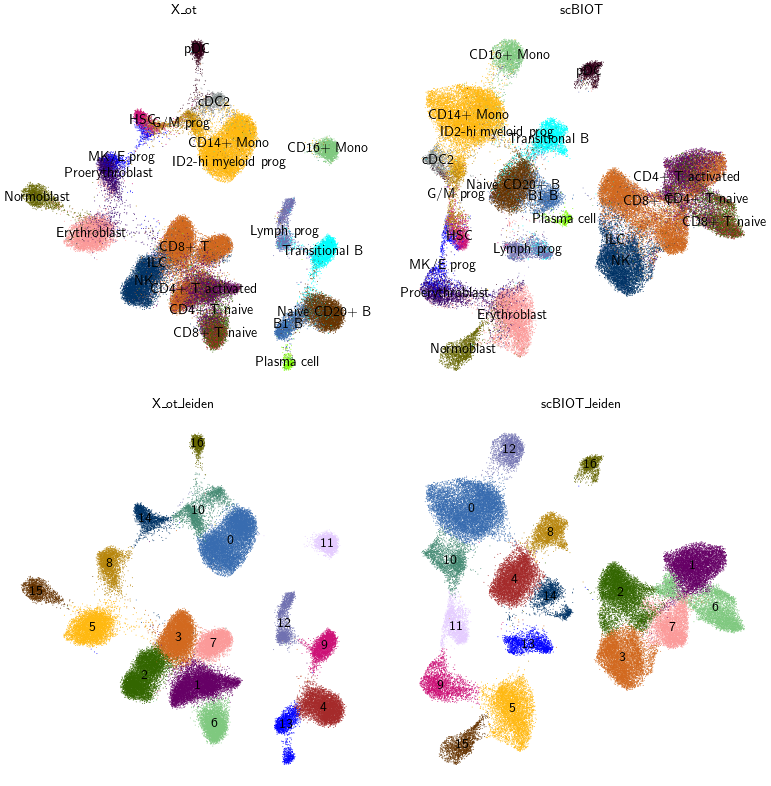

In [15]:
import matplotlib.pyplot as plt
import scanpy as sc


# 2 rows x len(methods) columns
fig, axes = plt.subplots(
    2,
    len(methods),
    figsize=(4 * len(methods), 8),
    squeeze=False  # ensures axes is a 2D array
)

for col, method in enumerate(methods):
    # 1) Top row (row=0): color by "batch"
    sc.pl.embedding(
        adata,
        basis=f"X_umap_{method}",  # The coordinates stored in adata.obsm["X_umap_{method}"]
        color="cell_type",            # Assume adata.obs["batch"] exists
        frameon=False,
        ax=axes[0, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        title=f"{method}"
    )

    # 2) Bottom row (row=1): color by the Leiden clusters for this method
    leiden_key = f"{method}_leiden"
    sc.pl.embedding(
        adata,
        basis=f"X_umap_{method}",
        color=leiden_key,         # Column in adata.obs
        frameon=False,
        ax=axes[1, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        # title=f"{method}"
    )

plt.tight_layout()
# fig.savefig("batch_and_leiden_per_embedding.pdf", dpi=300)
# plt.close(fig)


Embeddings: 100%|██████████| 3/3 [02:02<00:00, 40.97s/it]


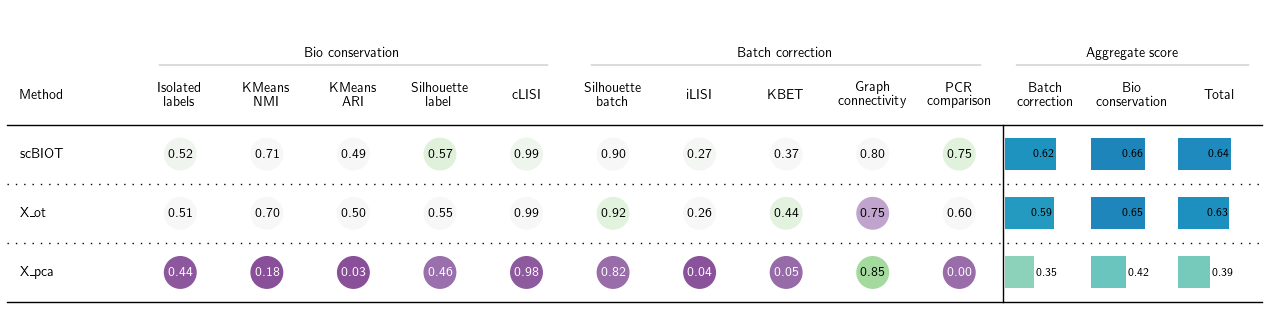

In [16]:
bm = Benchmarker(
    adata, 
    batch_key="batch",
    label_key="cell_type",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),    
    embedding_obsm_keys=["X_pca", "X_ot","scBIOT"], 
    n_jobs=32
    
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)